Este notebook está dedicado al analisis exploratorio de los 3 dataset creados en el notebook anterior llamado **Diabetes Globant Challenge Datasets**. Cada dataset se va a evaluar de forma independiente. Posteriormente, se realizaran comparaciones entre los dataset.

In [1]:
import pandas as pd
pd.set_option('display.max_columns', 60)
pd.set_option('display.max_rows', 200)
import warnings
warnings.filterwarnings('ignore')
import plotly.express as px

## Strack Dataset

In [2]:
Strack_dataset = pd.read_csv('/content/drive/MyDrive/Diabetes Globant Challenge/data/Strack_Diabetes.csv')
Strack_dataset.head(2)

,Unnamed: 0,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,4267,24437208,135,Caucasian,Female,[50-60),2,1,1,8,Cardiology,77,6,33,0,0,0,401,997,560,8,none,none,Steady,No,No,No,No,No,No,Down,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,<30
1,5827,29758806,378,Caucasian,Female,[50-60),3,1,1,2,Surgery-Neuro,49,1,11,0,0,0,722,305,250,3,none,none,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO


Primero vamos a conocer un poco más sobre la columna target **readmitted**

In [3]:
readmitted_freq = Strack_dataset['readmitted'].value_counts().reset_index()
readmitted_freq.columns = ['readmitted', 'Frecuencia']

fig = px.bar(readmitted_freq, x='readmitted', y='Frecuencia', title='Cantidad de readmitted', hover_data= 'Frecuencia')
fig.show()

Con la gráfica anterior observamos que:


*   El 60% de la data tiene como label **NO**
*   El 30% de los pacientes fueron reingresados en un periodo mayor a 30
*   El 10% de los pacientes fueron reingresados en un periodo menor a 30

Strack en su articulo decide unificar los pacientes reingresados. Por efectos de comparación se evaluará y analizará la relación entre los features con el target de la forma original y de la forma propuesta por Strack



### HbA1c

En esta sección vamos a explorar el efecto de la prueba del HbA1c que se ve reflejada en la columna **A1Cresult**. Vamos a comenzar con esta columna ya que es la columna que en trabajos previos se identifica como más importante.

Es importante aclarar que Strack, et al. concluyen que la importancia es realizar el test, no los resultados por lo que exploraremos ambas situaciones

In [4]:
A1C_freq = Strack_dataset.groupby(['A1Cresult'])['readmitted'].value_counts().reset_index()
fig = px.histogram(A1C_freq, x="readmitted", y="count",
                   color='A1Cresult', barmode='group', height=400)
fig.show()

De esta gráfica podemos concluir que al igual que menciona Strack solo se le hace prueba al 18% de los pacientes que ingresan. En los 3 escenarios la cantidad de gente que no le hicieron la prueba es del 80 al 82% para cada caso de readmision.

En los 3 escenarios se observa la misma distribución de los resultados del A1C.
Si los resultados de Strack son correctos, deberiamos encontrar alguna variable adicional que nos permita diferenciar los casos en los que se hizo la prueba y el paciente fue readmitido o no. Para esto vamos a explorar la prueba HbA1c junto con las siguientes columnas:



*   **diabetesMed**: Con el fin de ver si la medicación previa tiene efecto en el resultado del examen
*   **change**: Con el fin de ver si hubo un cambio de medicación cuando los resultados no fueron normales que eviten el reingreso. Tambien se va a mirar si hubo cambio de medicación cuando los resultados fueron normales que llevaran a un reingreso.
*   **diag_1**: Con el fin de ver cual fue el primer diagnostico, según el resultado de la prueba.
*   **medical_specialty**: Con el fin de ver si la especialidad del medico que atiende a la persona tiene influencia
*   **admission_type_id**: Con el fin de ver si hay relación entre el tipo de ingreso, el examen y un posible reingreso
*   **age**: Con el fin de determinar si hay relación entre los resultados del examen y la edad. Las otras variables demograficas como genero y raza serán explorados en un futuro pero por ahora a priori no se consideran.

#### diabetesMed

La prueba de hemoglobina glicosilada (HbA1c) es un examen de sangre para la diabetes tipo 2 y prediabetes. Mide el nivel promedio de glucosa o azúcar en la sangre durante los últimos tres meses. (*https://effectivehealthcare.ahrq.gov/health-topics/prueba-de-hemoglobina-glicosilada-hba1c*)

Basados en la definición de la prueba de HbA1c mi pensamiento inicial es suponer que si la persona se encuentra tomando el medicamento para la diabetes el resultado debería ser normal

In [5]:
diabetesMed_A1c = Strack_dataset.groupby(['diabetesMed'])['A1Cresult'].value_counts().reset_index()
diabetesMed_A1c = diabetesMed_A1c.sort_values(by=['A1Cresult'])
fig = px.histogram(diabetesMed_A1c, x="diabetesMed", y="count",
                   color='A1Cresult', barmode='group')
fig.show()

No vamos a tener en cuenta los 57134 (81.6%) de pacientes que no recibieron la prueba HbA1c.

La prueba HbA1c se considera alta por encima de 7% por lo que cuando hablemos de resultados altos se están sumando los resutlados >8% y >7%.


1.   De los pacientes restantes (12846), la mayoria estaba tomando medicina para la diabetes (82.9% o 10654).
2.   Entre los pacientes que no tomaban medicina la distribución es bastante pareja teniendo 1188 (54.2%) pacientes con resultados altos y 1004 (45.8%) pacientes con resultados normales. Aquí se cumple la lógica que indica que si no están tomando medicamento para la diabetes el examen debe dar resultados altos en la mayoría de los casos, aunque a priori esperaba una diferencia más marcada.
3.   Sorprendentemente, entre los pacientes que toman medicina para la diabetes la mayoría (7916) presenta resultados altos en el examen, en comparación con el 25.7% restante que muestra resultados normales.
4.   A pesar de los resultados presentados en el punto 3. es evidente en la figura que es más probable tener un resultado normal en el examen si se estaba tomando la medicina para la diabetes con anterioridad.

La intuición me indica que los pacientes con resultados altos, especialmente los que están tomando medicación para la diabetes van a tener un reingreso. Vamos a comprobarlo.



In [6]:
diabetesMed_A1c_read = Strack_dataset.groupby(['diabetesMed', 'A1Cresult'])['readmitted'].value_counts().reset_index()
diabetesMed_A1c_read = diabetesMed_A1c_read.sort_values(by=['A1Cresult'])
fig = px.histogram(diabetesMed_A1c_read, x="readmitted", y="count",
                   color='A1Cresult', facet_col='diabetesMed', barmode='group', height=400)
fig.show()

Conclusiones para pacientes que **NO** tomaban medicina para diabetes:


*   El 72% de los pacientes que no toman medicamento y el examen les sale normal no tienen reingreso
*   El 62% de los pacientes que no toman medicamento y el examen les sale alto tienen reingreso. Para este caso hay que revisar cuantos de ellos presentan un cambio en su medicación

Conclusiones para pacientes que **SI** tomaban medicina para diabetes:


*   El 60.5% de los pacientes que si toman medicamento y el examen les sale normal no tienen reingreso
*   El 60.4% de los pacientes que si toman medicamento y el examen les sale alto no tienen reingreso

Curiosidades:


*   Cuando no toman la medicina hay una diferencia porcentual muy importante según los resultados del examen
*   Cuando si toman la medicina no existe diferencia porcentual según los resultados del examen

Próximos paso:

Vamos a explorar la variable change para ver si encontramos algún patrón o algo que nos aclare un poco el panorama en el que estamos.

Preguntas actuales:


1.   Ese 72% que no toma medicina para la diabetes, tienen resutlados normales y no hicieron reingreso habran tenido cambio en su medicamente? Probablemente no (suposición)
2.   El 62% de pacientes que no toma medicamento, tuvo examenes altos pero no tuvo reingreso habrán tenido cambio en su medicamente? Probablemente si (Suposición)
3.   El resto de pacientes que no tomaban medicamento y tuvieron reingreso habran tenido cambio en su medicamento? Probablemente no (Suposición)
4.   Por qué el procentaje de pacientes que si tomaban medicamento no presentaron reingreso sin importar el resultado de los resultados
5.   Qué pasa con todos los que toman medicamento y tienen reingreso?












#### change

Vamos a tratar de responder las preguntas que surgen del análisis anterior

In [7]:
#Dataset de pacientes que No toman medicina, tienen el examen normal y no fueron readmitidos
df1 = Strack_dataset[(Strack_dataset['diabetesMed'] == 'No') &
                     (Strack_dataset['A1Cresult'] == 'Norm') &
                     (Strack_dataset['readmitted'] == 'NO')]
df1['change'].value_counts()

,count
change,
No,723


Confirmamos la suposición y concluimos que **Los pacientes que NO toman medicina y tienen el examen con resultados normales que no fueron readmitidos no tuvieron cambios en su medicación**

In [8]:
#Dataset de pacientes que No toman medicina, tienen el examen normal y si fueron readmitidos
df2 = Strack_dataset[(Strack_dataset['diabetesMed'] == 'No') &
                     (Strack_dataset['A1Cresult'] == 'Norm') &
                     (Strack_dataset['readmitted'] != 'NO')]
df2['change'].value_counts()

,count
change,
No,281


El resultado anterior nos da una conclusión más importante:


*   **Los pacientes que no toman medicamento y tienen resultados normales en el examen NO presentan cambios en su medicación, los que reingresan deben ser por otra variable diferente a la medicación**




In [9]:
#Dataset de pacientes que No toman medicina, tienen el examen alto y no fueron readmitidos
df3 = Strack_dataset[(Strack_dataset['diabetesMed'] == 'No') &
                     (Strack_dataset['A1Cresult'] != 'Norm') &
                     (Strack_dataset['A1Cresult'] != 'none') &
                     (Strack_dataset['readmitted'] == 'NO')]
df3['change'].value_counts()

,count
change,
No,741


In [10]:
#Dataset de pacientes que No toman medicina, tienen el examen alto y si fueron readmitidos
df4 = Strack_dataset[(Strack_dataset['diabetesMed'] == 'No') &
                     (Strack_dataset['A1Cresult'] != 'Norm') &
                     (Strack_dataset['A1Cresult'] != 'none') &
                     (Strack_dataset['readmitted'] != 'NO')]
df4['change'].value_counts()

,count
change,
No,447


Conclusión:

*  **Todos los pacientes que No toman medicina para la diabetes, no presentan cambios en su medicación**

Para este grupo de pacientes, el cambio de medicación no es un factor importante

In [11]:
#Dataset de pacientes que Si toman medicina, tienen el examen normal y no fueron readmitidos
df5 = Strack_dataset[(Strack_dataset['diabetesMed'] == 'Yes') &
                     (Strack_dataset['A1Cresult'] == 'Norm') &
                     (Strack_dataset['readmitted'] == 'NO')]
df5['change'].value_counts()

,count
change,
Ch,945
No,712


In [12]:
#Dataset de pacientes que Si toman medicina, tienen el examen normal y si fueron readmitidos
df6 = Strack_dataset[(Strack_dataset['diabetesMed'] == 'Yes') &
                     (Strack_dataset['A1Cresult'] == 'Norm') &
                     (Strack_dataset['readmitted'] != 'NO')]
df6['change'].value_counts()

,count
change,
Ch,664
No,417


Para el caso donde toman medicina, tienen el examen normal y no fueron readmitidos que sufrieron cambios en su formula es necesario entrar a mirar cual fue el cambio. Ya que lo normal es que con estas condiciones estos pacientes no sufran cambios en su formula.

El resto de casos donde los pacientes Si fueron readmitidos es necesario mirar los cambios que sufrieron y compararlo con lo que vamos a llamar el grupo de control que son los pacientes que si toman medicina, tienen el examen normal y no fueron readmitidos.

In [13]:
#Dataset de pacientes que Si toman medicina, tienen el examen alto y no fueron readmitidos
df7 = Strack_dataset[(Strack_dataset['diabetesMed'] == 'Yes') &
                     (Strack_dataset['A1Cresult'] != 'Norm') &
                     (Strack_dataset['A1Cresult'] != 'none') &
                     (Strack_dataset['readmitted'] == 'NO')]
df7['change'].value_counts()

,count
change,
Ch,3246
No,1540


In [14]:
#Dataset de pacientes que Si toman medicina, tienen el examen alto y si fueron readmitidos
df8 = Strack_dataset[(Strack_dataset['diabetesMed'] == 'Yes') &
                     (Strack_dataset['A1Cresult'] != 'Norm') &
                     (Strack_dataset['A1Cresult'] != 'none') &
                     (Strack_dataset['readmitted'] != 'NO')]
df8['change'].value_counts()

,count
change,
Ch,2227
No,903


La tendencia muestra que 69.1% de las veces que el paciente tiene los examenes altos y toma medicina, le hacen un ajuste en la dosis o le cambian el nombre generico del medicamento. De aquí podemos intuir que la dosis del medicamento o el nombre generico debe influir en si el paciente fue readmitido o no.

El caso donde No fueron readmitidos, si toman medicina, tienen resultados altos pero no presentan cambios en su medicina es necesario comparar dosis contra los pacientes que tienen el examen normal y no fueron readmitidos, ya que es posible que la dosis sea correcta pero todavía no ha tenido efecto.

#### Control group

In [15]:
#Grupo de control
control_group = Strack_dataset[(Strack_dataset['diabetesMed'] == 'Yes') &
                     (Strack_dataset['A1Cresult'] == 'Norm') &
                     (Strack_dataset['readmitted'] == 'NO') &
                     (Strack_dataset['change'] == 'No')]
len(control_group)

712

Vamos a mirar que podemos encontrar en el grupo de control.

En el grupo de control todas las medicinas deben tener 2 posibles valores, **No** o **Steady**. Para encontrar patrones vamos a aplicar dos

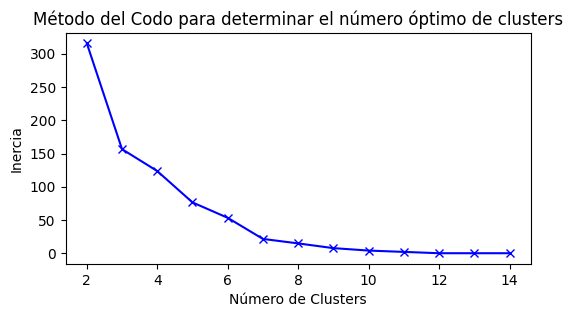

In [16]:
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

med_control_group = control_group[['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
                                   'glimepiride', 'acetohexamide', 'glipizide', 'glyburide',
                                   'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
                                   'miglitol', 'troglitazone', 'tolazamide', 'examide',
                                   'citoglipton', 'insulin', 'glyburide-metformin',
                                   'glipizide-metformin', 'glimepiride-pioglitazone',
                                   'metformin-rosiglitazone', 'metformin-pioglitazone']]

med_control_group_encoded = med_control_group.apply(LabelEncoder().fit_transform) #0 = No, 1 = Steady

inertia = []
K = range(2, 15)  # Prueba con diferentes números de clusters

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(med_control_group_encoded)
    inertia.append(kmeans.inertia_)

# Graficar la inercia vs. el número de clusters
plt.figure(figsize=(6, 3))
plt.plot(K, inertia, 'bx-')
plt.xlabel('Número de Clusters')
plt.ylabel('Inercia')
plt.title('Método del Codo para determinar el número óptimo de clusters')
plt.show()

In [17]:
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(med_control_group_encoded)

med_control_group['Cluster'] = clusters
cluster0 = med_control_group[med_control_group['Cluster'] == 0]
cluster1 = med_control_group[med_control_group['Cluster'] == 1]
cluster2 = med_control_group[med_control_group['Cluster'] == 2]

vamos a ver que valores distintos tenemos en cada cluster. Esto para identificar las medicinas que siempre se dan, nunca se dan o pueden variar

In [18]:
for column in cluster0.columns:
  print(f"{column}: {cluster0[column].nunique()}")
print("Tamaño del cluster0:", len(cluster0))
cluster0.head(1)

metformin: 1
repaglinide: 1
nateglinide: 1
chlorpropamide: 1
glimepiride: 1
acetohexamide: 1
glipizide: 1
glyburide: 1
tolbutamide: 1
pioglitazone: 1
rosiglitazone: 1
acarbose: 1
miglitol: 1
troglitazone: 1
tolazamide: 1
examide: 1
citoglipton: 1
insulin: 1
glyburide-metformin: 1
glipizide-metformin: 1
glimepiride-pioglitazone: 1
metformin-rosiglitazone: 1
metformin-pioglitazone: 1
Cluster: 1
Tamaño del cluster0: 120


,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,Cluster
335,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,0


Este cluster se caracteriza por tener 120 pacientes los cuales la unica medicina que toman es **metformin**

In [19]:
for column in cluster1.columns:
  print(f"{column}: {cluster1[column].nunique()}")
print("Tamaño del cluster1:", len(cluster1))
cluster1.head(1)

metformin: 1
repaglinide: 1
nateglinide: 1
chlorpropamide: 1
glimepiride: 1
acetohexamide: 1
glipizide: 1
glyburide: 1
tolbutamide: 1
pioglitazone: 1
rosiglitazone: 1
acarbose: 1
miglitol: 1
troglitazone: 1
tolazamide: 1
examide: 1
citoglipton: 1
insulin: 1
glyburide-metformin: 1
glipizide-metformin: 1
glimepiride-pioglitazone: 1
metformin-rosiglitazone: 1
metformin-pioglitazone: 1
Cluster: 1
Tamaño del cluster1: 394


,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,Cluster
32,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,1


Este cluster se caracteriza por tener 394 pacientes los cuales la unica medicina que toman es **insulin**

In [20]:
for column in cluster2.columns:
  print(f"{column}: {cluster2[column].nunique()}")
print("Tamaño del cluster2:", len(cluster2))

metformin: 1
repaglinide: 2
nateglinide: 2
chlorpropamide: 2
glimepiride: 2
acetohexamide: 1
glipizide: 2
glyburide: 2
tolbutamide: 1
pioglitazone: 2
rosiglitazone: 2
acarbose: 2
miglitol: 1
troglitazone: 1
tolazamide: 2
examide: 1
citoglipton: 1
insulin: 1
glyburide-metformin: 1
glipizide-metformin: 1
glimepiride-pioglitazone: 1
metformin-rosiglitazone: 1
metformin-pioglitazone: 1
Cluster: 1
Tamaño del cluster2: 198


Para el cluster 2 con ver la primera fila sabríamos cuales pueden tener Steady o No en cada columna. Despues de esto, estamos interesados en averiguar si hay combinación de medicamentos o si al igual que los cluster anteriores solo se aplican de a uno

In [21]:
def check_multiple_columns_for_value(df, value): #Con esta función vamos a buscar las filas donde la palabra Steady se encuentre en mas de 1 columna
  return (df == value).all(axis=1)

value_to_check = 'Steady'
rows_with_same_value = check_multiple_columns_for_value(cluster2, value_to_check)

# Print the rows that have 'No' in all specified columns.
print(cluster2[rows_with_same_value])

Empty DataFrame
Columns: [metformin, repaglinide, nateglinide, chlorpropamide, glimepiride, acetohexamide, glipizide, glyburide, tolbutamide, pioglitazone, rosiglitazone, acarbose, miglitol, troglitazone, tolazamide, examide, citoglipton, insulin, glyburide-metformin, glipizide-metformin, glimepiride-pioglitazone, metformin-rosiglitazone, metformin-pioglitazone, Cluster]
Index: []


In [22]:
cluster2.head(1)

,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,Cluster
24,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,2


El cluster 2 son 198 personas que solo toman un medicamento que puede variar entre:


*   repaglinide
*   nateglinide
*   chlorpropamide
*   glimepiride
*   glipizide
*   glyburide
*   pioglitazone
*   rosiglitazone
*   acarbose
*   tolazamide



Ahora vamos a graficar la cantidad de personas que toma cada medicamento dentro del grupo de control. Recordemos que el grupo de control toma solo 1 medicamento



In [23]:
frecuencia_steady = cluster2.apply(lambda col: (col == 'Steady').sum())
frecuencia_steady += cluster1.apply(lambda col: (col == 'Steady').sum())
frecuencia_steady += cluster0.apply(lambda col: (col == 'Steady').sum())
frecuencia_steady_df = frecuencia_steady.reset_index()
frecuencia_steady_df.columns = ['Medicina', 'Cantidad de pacientes']
frecuencia_steady_df = frecuencia_steady_df[frecuencia_steady_df['Cantidad de pacientes'] != 0]
fig = px.bar(frecuencia_steady_df, x='Medicina', y='Cantidad de pacientes',
             title='Cantidad de pacientes vs Medicina')
fig.show()

Conclusiones grupo de control


*   Siempre toman 1 sola medicina
*   La insulina, metformin, glipizide, glyburide van a ser consideradas las medicinas que al tomarse solas deberían dar buenos resultados en el examen y evitar la readmisión. Se toman estás 4 ya que ellas corresponde al 87.7% del grupo de control.

Las otras medicinas fueron eficaces en tan pocos casos que no se pueden tomar como referencia. Por lo tanto serán excluidas del grupo de control.



In [24]:
control_group = control_group[(control_group['metformin'] == 'Steady') |
                              (control_group['glipizide'] == 'Steady') |
                              (control_group['glyburide'] == 'Steady') |
                              (control_group['insulin'] == 'Steady')]
len(control_group)

625

Ahora para el grupo de control vamos a explorar un poco los siguientes features:


*   **diag_1**
*   **medical_specialty**
*   **admission_type_id**
*   **age**

Los códigos del **diag_1** corresponden a los ICD-9 codes reportados por  *International Statistical Classification of Diseases and Related Health Problems*.

Los codigos van por rangos y tienen un significado por rango, por lo tanto vamos a agrupar los códigos en los rangos (*https://www.aapc.com/codes/icd9-codes-range/*)

In [25]:
def replace_diag(diag):
  try:
    diag = float(diag)
    if 1 <= diag <= 139:
      return 'Infectious and parasitic diseases'
    elif 140 <= diag <= 239:
      return 'Neoplasms'
    elif 240 <= diag <= 279:
      return 'Endocrine, nutritional and metabolic diseases, and immunity disorders'
    elif 280 <= diag <= 289:
      return 'Diseases of the blood and blood-forming organs'
    elif 290 <= diag <= 319:
      return 'Mental disorders'
    elif 320 <= diag <= 389:
      return 'Diseases of the nervous system and sense organs'
    elif 390 <= diag <= 459:
      return 'Diseases of the circulatory system'
    elif 460 <= diag <= 519:
      return 'Diseases of the respiratory system'
    elif 520 <= diag <= 579:
      return 'Diseases of the digestive system'
    elif 580 <= diag <= 629:
      return 'Diseases of the genitourinary system'
    elif 630 <= diag <= 679:
      return 'Complications of pregnancy, childbirth, and the puerperium'
    elif 680 <= diag <= 709:
      return 'Diseases of the skin and subcutaneous tissue'
    elif 710 <= diag <= 739:
      return 'Diseases of the musculoskeletal system and connective tissue'
    elif 740 <= diag <= 759:
      return 'Congenital anomalies'
    elif 760 <= diag <= 779:
      return 'Certain conditions originating in the perinatal period'
    elif 780 <= diag <= 799:
      return 'Symptoms, signs, and ill-defined conditions'
    elif 800 <= diag <= 999:
      return 'Injury and poisoning'
    else:
      return 'Other'
  except ValueError:
    if diag.startswith('V'):
      return 'Supplementary Classification of Factors Influencing Health Status and Contact with Health Services'
    elif diag.startswith('E'):
      return 'External Causes of Morbidity'
    else:
      return 'none'

control_group['diag_1_range'] = control_group['diag_1'].apply(replace_diag)

In [26]:
diag1_freq_control = control_group['diag_1_range'].value_counts().reset_index()
diag1_freq_control.columns = ['diag_1_range', 'Frecuencia']

fig = px.bar(diag1_freq_control, x='diag_1_range', y='Frecuencia', title='diag_1', hover_data= 'Frecuencia')
fig.show()

Se encuentra una variedad de diagnosticos. Sin embargo, la mayor esta relacionado con problemas circulatorios

In [27]:
med_freq_control = control_group['medical_specialty'].value_counts().reset_index()
med_freq_control.columns = ['medical_specialty', 'Frecuencia']

fig = px.bar(med_freq_control, x='medical_specialty', y='Frecuencia', title='medical_specialty', hover_data= 'Frecuencia')
fig.show()

La especialidad medica no da información relevante en ningún sentido. Incluso la mayoria de información se encuentra sin valor o missing

In [28]:
admin_freq_control = control_group['admission_type_id'].value_counts().reset_index()
admin_freq_control.columns = ['admission_type_id', 'Frecuencia']

fig = px.bar(admin_freq_control, x='admission_type_id', y='Frecuencia', title='admission_type_id', hover_data= 'Frecuencia')
fig.show()

Aquí vemos una tendencia muy marcada para ingresos de tipo 1, 2 y 3 que corresponden a Emergencia, Urgencia y electiva, respectivamente.

In [29]:
age_freq_control = control_group['age'].value_counts().reset_index()
age_freq_control.columns = ['age', 'Frecuencia']

fig = px.bar(age_freq_control, x='age', y='Frecuencia', title='age', hover_data= 'Frecuencia')
fig.show()

La distribución por rangos de edades tampoco muestra un patrón claro para el grupo de control. Los valores con pocos casos tienen sentido ya que lógicamente la enfermedad no afecta fuertemente a grupo poblacionales jovenes y el grupo de muy mayores (90 a 100) no es un apoblación significativa teniendo en cuenta la vida media de una persona.

Hasta ahora tenemos una idea inicial de esos pacientes que venían tomando medicinas, el examen les salío normal y no tuvieron reingreso, este sería el caso ideal y vamos a ver si estos patrones se repiten en otros grupos de interes.

Las conclusiones principales y más marcadas son:

*   Solo toman un medicamento que puede ser insulina, metformin, glipizide, glyburide
*   Suelen ingresar por emergencias



#### Grupo 1

Este grupo se caracteriza por tomar medicinas, tener examenes con resultados normales y pudieron o no ser readmitidos. Aquí se excluyen los que no fueron readmitidos y no tuvieron cambios en su medicina ya que hacen parte del grupo de control

In [30]:
group1 = Strack_dataset[(Strack_dataset['diabetesMed'] == 'Yes') &
                     (Strack_dataset['A1Cresult'] == 'Norm') &
                     (((Strack_dataset['readmitted'] == 'NO') & (Strack_dataset['change'] != 'No')) | (Strack_dataset['readmitted'] != 'NO'))]
len(group1)

2026

La cantidad de data que tiene el grupo se muestra con el fin de controlar la trasabilidad del grupo y verificar que la cantidad de data corresponde a lo previamente visto

En este grupo tenemos 3 casos

*   Grupo 1.1 = los que recibieron cambios en su medicación y no fueron reingresados
*   Grupo 1.2 = los que recibieron cambios en su medicación y si fueron reingresados
*   Grupo 1.3 = los que no recibieron cambios en su medicación y si fueron reingresados

En estos 3 grupos vamos a buscar patrones en las medicinas

In [31]:
group1_1 = group1[(group1['change'] != 'No') & (group1['readmitted'] == 'NO')]
group1_2 = group1[(group1['change'] != 'No') & (group1['readmitted'] != 'NO')]
group1_3 = group1[(group1['change'] == 'No') & (group1['readmitted'] != 'NO')]
len(group1_1), len(group1_2), len(group1_3)

(945, 664, 417)

##### Grupo 1.1

In [32]:
med_group1_1 = group1_1[['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
                                   'glimepiride', 'acetohexamide', 'glipizide', 'glyburide',
                                   'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
                                   'miglitol', 'troglitazone', 'tolazamide', 'examide',
                                   'citoglipton', 'insulin', 'glyburide-metformin',
                                   'glipizide-metformin', 'glimepiride-pioglitazone',
                                   'metformin-rosiglitazone', 'metformin-pioglitazone']]

med_group1_1 = med_group1_1.loc[:, med_group1_1.nunique() > 1] #Quitamos las columnas que solo tienen un valor constante
med_group1_1['Medicinas_tomadas'] = med_group1_1.apply(lambda row: (row != 'No').sum(), axis=1)
fig = px.histogram(med_group1_1, x='Medicinas_tomadas', nbins=11, title='Distribución del número de medicinas tomadas al tiempo')
fig.show()

Ahora vamos a ver cuando es 1 sola cual es. (Esperamos que sea una de las 4 de control) y cuando son 2 y 3 (Cuales están y cuál fue la instrucción).

En este punto es importante notar que estamos suponiendo que un Down continúa tomando el medicamento, pero realmente puede ser que le bajaron la dosis a 0. Esto es algo que no tenemos explicitamente pero que podríamos intuir dependiendo del caso

In [33]:
med_group1_1_1 = med_group1_1[med_group1_1['Medicinas_tomadas'] == 1]
def find_column_with_non_no_value(row):
  for column in row.index:
    if row[column] != 'No':
      return column
  return None

med_group1_1_1['Columna_Medicina'] = med_group1_1_1.apply(find_column_with_non_no_value, axis=1)
med_group1_1_1['Columna_Medicina'].value_counts()

,count
Columna_Medicina,
insulin,273
glyburide,10
metformin,9
glipizide,6
glimepiride,4


Dentro de las medicinas que se toman están las 4 que consideramos en el grupo de control. Esto tiene sentido. Vamos a ver si les aumentaron la dosis o si la redujeron

In [34]:
med_group1_1_1['insulin'].value_counts()

,count
insulin,
Down,153
Up,120
No,29


In [35]:
med_group1_1_1['glyburide'].value_counts()

,count
glyburide,
No,292
Up,7
Down,3


In [36]:
med_group1_1_1['metformin'].value_counts()

,count
metformin,
No,293
Up,5
Down,4


In [37]:
med_group1_1_1['glipizide'].value_counts()

,count
glipizide,
No,296
Up,4
Down,2


La conclusión con este grupo es que estaban tomando las medicinas adecuadas pero en dosis inadecuadas

In [38]:
med_group1_1_2 = med_group1_1[med_group1_1['Medicinas_tomadas'] == 2]
def find_columns_with_non_no_values(row):
  columns_with_non_no_values = []
  for column in row.index:
    if row[column] != 'No':
      columns_with_non_no_values.append(column)
  return columns_with_non_no_values

med_group1_1_2['Columnas_Medicinas'] = med_group1_1_2.apply(find_columns_with_non_no_values, axis=1)
med_group1_1_2['Columnas_Medicinas'] .value_counts()

,count
Columnas_Medicinas,
"[metformin, insulin, Medicinas_tomadas]",117
"[glipizide, insulin, Medicinas_tomadas]",60
"[pioglitazone, insulin, Medicinas_tomadas]",44
"[glyburide, insulin, Medicinas_tomadas]",44
"[metformin, glyburide, Medicinas_tomadas]",28
"[glimepiride, insulin, Medicinas_tomadas]",26
"[rosiglitazone, insulin, Medicinas_tomadas]",24
"[metformin, glipizide, Medicinas_tomadas]",15
"[metformin, rosiglitazone, Medicinas_tomadas]",10


En los casos más significativos de este grupo que toma 2 medicamentos se tiene que **siempre** está al menos 1 de las 4 medicinas que se identificaron en el grupo de control

In [39]:
med_group1_1_3 = med_group1_1[med_group1_1['Medicinas_tomadas'] == 3]

med_group1_1_3['Columnas_Medicinas'] = med_group1_1_3.apply(find_columns_with_non_no_values, axis=1)
med_group1_1_3['Columnas_Medicinas'] .value_counts()

,count
Columnas_Medicinas,
"[metformin, glipizide, insulin, Medicinas_tomadas]",31
"[metformin, pioglitazone, insulin, Medicinas_tomadas]",24
"[metformin, glyburide, insulin, Medicinas_tomadas]",20
"[metformin, rosiglitazone, insulin, Medicinas_tomadas]",16
"[glipizide, pioglitazone, insulin, Medicinas_tomadas]",10
"[glyburide, rosiglitazone, insulin, Medicinas_tomadas]",8
"[metformin, glimepiride, insulin, Medicinas_tomadas]",7
"[glimepiride, rosiglitazone, insulin, Medicinas_tomadas]",5
"[metformin, repaglinide, insulin, Medicinas_tomadas]",5


Al ver los resultados de las personas que toman 3 medicamentos al tiempo podemos concluir que los 4 medicamentos identificados en el grupo de control son fundamentales, especialmente la insulina el metmorfin

##### Grupo 1.2

En este grupo hubo cambios de medicamento pero fueron readmitidos

In [40]:
med_group1_2 = group1_2[['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
                                   'glimepiride', 'acetohexamide', 'glipizide', 'glyburide',
                                   'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
                                   'miglitol', 'troglitazone', 'tolazamide', 'examide',
                                   'citoglipton', 'insulin', 'glyburide-metformin',
                                   'glipizide-metformin', 'glimepiride-pioglitazone',
                                   'metformin-rosiglitazone', 'metformin-pioglitazone']]

med_group1_2 = med_group1_2.loc[:, med_group1_2.nunique() > 1] #Quitamos las columnas que solo tienen un valor constante
med_group1_2['Medicinas_tomadas'] = med_group1_2.apply(lambda row: (row != 'No').sum(), axis=1)
fig = px.histogram(med_group1_2, x='Medicinas_tomadas', nbins=11, title='Distribución del número de medicinas tomadas al tiempo')
fig.show()

In [41]:
med_group1_2_1 = med_group1_2[med_group1_2['Medicinas_tomadas'] == 1]

med_group1_2_1['Columna_Medicina'] = med_group1_2_1.apply(find_column_with_non_no_value, axis=1)
med_group1_2_1['Columna_Medicina'].value_counts()

,count
Columna_Medicina,
insulin,208
glipizide,10
glyburide,7
glimepiride,4
metformin,2
rosiglitazone,1


In [42]:
med_group1_2_1['insulin'].value_counts()

,count
insulin,
Down,115
Up,93
No,24


Con la insulina vemos un comportamiento muy similar al observado en el grupo anterior

In [43]:
med_group1_2_1['glyburide'].value_counts()

,count
glyburide,
No,225
Up,5
Down,2


In [44]:
med_group1_2_1['metformin'].value_counts()

,count
metformin,
No,230
Down,2


In [45]:
med_group1_2_1['glipizide'].value_counts()

,count
glipizide,
No,222
Down,7
Up,3


Estos resultados muestran que recibir unicamente insulina no siempre lleva a no volver al hospital. Las demás medicinas tienen tan poco información que no son significativas

In [46]:
med_group1_2_2 = med_group1_2[med_group1_2['Medicinas_tomadas'] == 2]

med_group1_2_2['Columnas_Medicinas'] = med_group1_2_2.apply(find_columns_with_non_no_values, axis=1)
med_group1_2_2['Columnas_Medicinas'] .value_counts()

,count
Columnas_Medicinas,
"[glipizide, insulin, Medicinas_tomadas]",60
"[metformin, insulin, Medicinas_tomadas]",59
"[glyburide, insulin, Medicinas_tomadas]",32
"[pioglitazone, insulin, Medicinas_tomadas]",30
"[rosiglitazone, insulin, Medicinas_tomadas]",19
"[glimepiride, insulin, Medicinas_tomadas]",19
"[metformin, glyburide, Medicinas_tomadas]",14
"[metformin, rosiglitazone, Medicinas_tomadas]",12
"[metformin, glipizide, Medicinas_tomadas]",8


In [47]:
med_group1_2_3 = med_group1_2[med_group1_2['Medicinas_tomadas'] == 3]

med_group1_2_3['Columnas_Medicinas'] = med_group1_2_3.apply(find_columns_with_non_no_values, axis=1)
med_group1_2_3['Columnas_Medicinas'] .value_counts()

,count
Columnas_Medicinas,
"[metformin, glyburide, insulin, Medicinas_tomadas]",17
"[metformin, glipizide, insulin, Medicinas_tomadas]",16
"[metformin, pioglitazone, insulin, Medicinas_tomadas]",15
"[metformin, rosiglitazone, insulin, Medicinas_tomadas]",12
"[glipizide, pioglitazone, insulin, Medicinas_tomadas]",8
"[glipizide, rosiglitazone, insulin, Medicinas_tomadas]",6
"[metformin, glimepiride, insulin, Medicinas_tomadas]",5
"[glimepiride, pioglitazone, insulin, Medicinas_tomadas]",5
"[metformin, glyburide, pioglitazone, Medicinas_tomadas]",4


Al observar los resultados de este grupo encontramos que la combinación de medicamentos no parece ser un indicador extremadamente diciente. Sin embargo, cuando tenemos la presencia de alguno de los 4 medicamentos de control las posibilidades de no reingresar son mayores a las de reingresar. Por lo tanto, seguimos con la hipotesis que tomar las alguna de las 4 medicinas es positivo y es lo ideal.

##### Grupo 1.3

In [48]:
med_group1_3 = group1_3[['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
                                   'glimepiride', 'acetohexamide', 'glipizide', 'glyburide',
                                   'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
                                   'miglitol', 'troglitazone', 'tolazamide', 'examide',
                                   'citoglipton', 'insulin', 'glyburide-metformin',
                                   'glipizide-metformin', 'glimepiride-pioglitazone',
                                   'metformin-rosiglitazone', 'metformin-pioglitazone']]

med_group1_3 = med_group1_3.loc[:, med_group1_3.nunique() > 1] #Quitamos las columnas que solo tienen un valor constante
med_group1_3['Medicinas_tomadas'] = med_group1_3.apply(lambda row: (row != 'No').sum(), axis=1)
fig = px.histogram(med_group1_3, x='Medicinas_tomadas', nbins=11, title='Distribución del número de medicinas tomadas al tiempo')
fig.show()

Todos en este grupo toman únicamente un solo medicamento. Supongo que es insulina

In [49]:
med_group1_3_1 = med_group1_3[med_group1_3['Medicinas_tomadas'] == 1]

med_group1_3_1['Columna_Medicina'] = med_group1_3_1.apply(find_column_with_non_no_value, axis=1)
med_group1_3_1['Columna_Medicina'].value_counts()

,count
Columna_Medicina,
insulin,194
metformin,75
glipizide,43
glyburide,43
rosiglitazone,19
pioglitazone,18
glimepiride,14
repaglinide,7
glyburide-metformin,2


La mayoria es insulina y/o una de las 4 principales. En este caso suponemos que la dosis es incorrecta.

Por último vamos a mirar si las personas de este grupo ingresaron por emergencia, urgencia o electiva.

In [50]:
admin_freq_1_3 = group1_3['admission_type_id'].value_counts().reset_index()
admin_freq_1_3.columns = ['admission_type_id', 'Frecuencia']

fig = px.bar(admin_freq_1_3, x='admission_type_id', y='Frecuencia', title='admission_type_id', hover_data= 'Frecuencia')
fig.show()

A pesar de que existen algunos casos que con las 4 medicinas tenemos readmisión, tambien podemos ver la tendencia a tener examenes en rangos normales gracias a las medicinas.

Adicionalmente, se observa que la cantidad de casos que entran por urgencia es muy baja, la mayoría son emergencias.

**Conclusión: Las medicinas identificadas en el grupo de control siguen apareciendo cuando los resutlados de los examenes son normales y se observa que reduce la cantidad de casos que reingresan por urgencia.**

#### Grupo 2

Este grupo se caracteriza porque toman medicinas y tienen el examen con resultados altos

In [51]:
group2 = Strack_dataset[(Strack_dataset['diabetesMed'] == 'Yes') &
                        (Strack_dataset['A1Cresult']!= 'Norm') &
                        (Strack_dataset['A1Cresult']!= 'none')]
len(group2)

7916

La cantidad de data que tiene el grupo se muestra con el fin de controlar la trasabilidad del grupo y verificar que la cantidad de data corresponde a lo previamente visto.

Vamos a revisar cuántas medicinas toman, qué medicinas toman y qué combinación de medicinas toman

In [52]:
med_group2 = group2[['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
                                   'glimepiride', 'acetohexamide', 'glipizide', 'glyburide',
                                   'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
                                   'miglitol', 'troglitazone', 'tolazamide', 'examide',
                                   'citoglipton', 'insulin', 'glyburide-metformin',
                                   'glipizide-metformin', 'glimepiride-pioglitazone',
                                   'metformin-rosiglitazone', 'metformin-pioglitazone', 'readmitted']]

med_group2 = med_group2.loc[:, med_group2.nunique() > 1] #Quitamos las columnas que solo tienen un valor constante
med_group2['Medicinas_tomadas'] = med_group2.apply(lambda row: (row != 'No').sum(), axis=1) - 1 #Porque la columna de readmitted agrega un valor extra
fig = px.histogram(med_group2, x='Medicinas_tomadas', nbins=11, title='Distribución del número de medicinas tomadas al tiempo',
                   facet_col='readmitted')
fig.show()

##### Grupo 2.1

In [53]:
med_group2_1 = med_group2[(med_group2['Medicinas_tomadas'] == 1) &
                              (med_group2['readmitted'] == 'NO')]

med_group2_1['Columna_Medicina'] = med_group2_1.apply(find_columns_with_non_no_values, axis=1)
med_group2_1['Columna_Medicina'].value_counts()

,count
Columna_Medicina,
"[insulin, readmitted, Medicinas_tomadas]",1888
"[metformin, readmitted, Medicinas_tomadas]",226
"[glipizide, readmitted, Medicinas_tomadas]",148
"[glyburide, readmitted, Medicinas_tomadas]",146
"[glimepiride, readmitted, Medicinas_tomadas]",55
"[pioglitazone, readmitted, Medicinas_tomadas]",42
"[rosiglitazone, readmitted, Medicinas_tomadas]",35
"[repaglinide, readmitted, Medicinas_tomadas]",9
"[glyburide-metformin, readmitted, Medicinas_tomadas]",7


A pesar de tener el examen alto, los pacientes que toman una sola medicina y no fueron readmitidos tienen en común que la mayoría toma una de las 4 drogas del grupo de control. Es probable que su examen no normal porque la medicina estaba comenzando a hacer el efecto.

In [54]:
group2_1 = group2[(group2['readmitted'] == 'NO')]

admin_freq_2_1 = group2_1['admission_type_id'].value_counts().reset_index()
admin_freq_2_1.columns = ['admission_type_id', 'Frecuencia']

fig = px.bar(admin_freq_2_1, x='admission_type_id', y='Frecuencia', title='admission_type_id', hover_data= 'Frecuencia')
fig.show()

Volvemos a ver una tendencia a que la mayoría de pacientes vienen por emergencia.

##### Grupo 2.2

In [55]:
med_group2_2 = med_group2[(med_group2['Medicinas_tomadas'] == 1) &
                              (med_group2['readmitted'] != 'NO')]

med_group2_2['Columna_Medicina'] = med_group2_2.apply(find_columns_with_non_no_values, axis=1)
med_group2_2['Columna_Medicina'].value_counts()

,count
Columna_Medicina,
"[insulin, readmitted, Medicinas_tomadas]",1218
"[metformin, readmitted, Medicinas_tomadas]",120
"[glipizide, readmitted, Medicinas_tomadas]",113
"[glyburide, readmitted, Medicinas_tomadas]",91
"[pioglitazone, readmitted, Medicinas_tomadas]",37
"[glimepiride, readmitted, Medicinas_tomadas]",35
"[rosiglitazone, readmitted, Medicinas_tomadas]",29
"[repaglinide, readmitted, Medicinas_tomadas]",8
"[chlorpropamide, readmitted, Medicinas_tomadas]",3


Los pacientes que toman una medicina y si fueron readmitidos tambien tienen en su mayoria las 4 medicinas. Sin embargo la frecuencia de cada medicina es menor al grupo opuesto. En cantidad se continúa pensando que estás medicinas aumentan la probabilidad de no ser readmitido.

Ahora vamos a ver si llegan por emergencia o urgencia.

In [56]:
group2_2 = group2[(group2['readmitted'] != 'NO')]

admin_freq_2_2 = group2_2['admission_type_id'].value_counts().reset_index()
admin_freq_2_2.columns = ['admission_type_id', 'Frecuencia']

fig = px.bar(admin_freq_2_2, x='admission_type_id', y='Frecuencia', title='admission_type_id', hover_data= 'Frecuencia')
fig.show()

Tenemos la misma tendencia de que la mayoria de pacientes vienen por emergencia. Está variable pierde importancia por el momento

En este punto tenemos caracterizado 4 grupos, el grupo de control, grupo 1, grupo 2 y el grupo de los pacientes que no tomaban medicina. Este análisis corresponde al 18.4% de la data total del dataset de Strack. Ahora vamos a mirar si encontramos relaciones significativas para el resto de datos a los cuales no les hicieron el examen de HbA1c.

### Sin HbA1c

En su paper Strack encuentra una relacion entre la aplicacion del examen y la readmision. Ya que la probabilidad de readmision es menor si se aplico el examen.

En nuestro estudio hemos visto que sin importar los resultados del examen existe una tendencia a que la mayoria no presente readmision. Adicionalmente, observamos unas medicinas que se cree van a presentar el mismo comportamiento. Donde su presencia reduce la probabilidad de readmision.

Ahora vamos a hacer un estudio corto para verificar del 80% restante de paciente cuantos presentan readmision, cual es su motivo de ingreso y si en este grupo hay cambios de medicamento y si esta relacionado con la readmision

In [57]:
A1c_no = Strack_dataset[(Strack_dataset['A1Cresult'] == 'none')]
len(A1c_no)

57134

Primero vamos a mirar la distribucion de readmitidos de los pacientes a los que no se les hizo el examen

In [58]:
A1C_no_freq = A1c_no.groupby(['change'])['readmitted'].value_counts().reset_index()
fig = px.histogram(A1C_no_freq, x="readmitted", y="count",
                   barmode='group', height=400)
fig.show()

En est emomento vamos a realizar unos calculos rapidos

*  El porcentaje de readmitidos cuando no les hicieron la prueba es del 58,7%
*  El porcentaje de readmitidos cuando si les hacen la prueba es del 61,5%

Esta pequeña, pero sutil diferencia es a la que hace referencia Strack y la cual acabamos de confirmar.

En este dataset vale la pena revisar las medicinas que estan tomando los de readmision, sin embargo, vamos a pasar a los siguientes dataset en aras de cubrir terreno nuevo

Finalizado este análisis, vamos a continuar con los dataset pendientes. El dataset Hernandez tiene como diferencia que los pacientes pueden tener reingreso. Por esto, el análisis en este dataset se va a enfocar en los clientes que tienen más de 1 reingreso

## Hernandez Dataset

En el dataset Hernandez tenemos la informacion de todos los pacientes y sus reingresos, menos de los muertos. Este dataset lo vamos a modificar un poco y solo vamos a estudiar a los pacientes que tuvieron reingresos

In [121]:
Hernandez = pd.read_csv('/content/drive/MyDrive/Diabetes Globant Challenge/data/Hernandez_Diabetes.csv')
Hernandez.head(2)

,Unnamed: 0,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,all_time_number_inpatient
0,4267,24437208,135,Caucasian,Female,[50-60),2,1,1,8,Cardiology,77,6,33,0,0,0,401,997,560,8,none,none,Steady,No,No,No,No,No,No,Down,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,<30,1
1,4780,26264286,135,Caucasian,Female,[50-60),1,1,7,3,Surgery-Cardiovascular/Thoracic,31,1,14,0,0,1,998,41,250,5,none,none,Steady,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Ch,Yes,>30,2


In [122]:
Hernandez = Hernandez[Hernandez['patient_nbr'].duplicated(keep=False)]
len(Hernandez)

46158

Hasta aquí quitamos los duplicados y en teoria nos deberíamos quedar solo con las personas que fueron mas de una vez al hospital. Sin embargo, en aras de limpiar la data vamos a remover un caso que no debería pasar que se ha encontrado que ocurre. El caso donde el paciente en su primera visita no fue readmitido.

In [123]:
patients_with_no_readmitted_first_encounter = Hernandez.sort_values(['patient_nbr', 'encounter_id']).groupby('patient_nbr').first()[
Hernandez.sort_values(['patient_nbr', 'encounter_id']).groupby('patient_nbr').first()['readmitted'] == 'NO'].index.tolist()

Hernandez = Hernandez[~Hernandez['patient_nbr'].isin(patients_with_no_readmitted_first_encounter)]
len(Hernandez)

45574

Inicialmente vamos a mirar cual es el tipo de admision mas comun de reingreso

In [124]:
admin_type = Hernandez.groupby(['admission_type_id'])['readmitted'].value_counts().reset_index()
fig = px.bar(admin_type, x="admission_type_id", y="count", color = "readmitted",
                   barmode='group', height=400)
fig.show()

La proporcion es similar segun los 3 principales tipos de ingreso.

Vamos a ver la cantidad de dias en promedio que se quedan por reingreso

In [125]:
time_hosp_read = Hernandez.groupby(['readmitted'])['time_in_hospital'].mean().reset_index()
fig = px.bar(time_hosp_read, x="readmitted", y="time_in_hospital",
                   barmode='group', height=400)
fig.show()

Aqui no encontramos ninguna diferencia entre el tiempo promedio en el hospital

Vamos a finalizar este analisis mirando 3 cosas. La cantidad promedio de reingresos, la cantidad de medicinas que tomaban y el diagnostico

In [126]:
max_readmitted = Hernandez.groupby(['patient_nbr'])['all_time_number_inpatient'].max().reset_index()
fig = px.histogram(max_readmitted, x='all_time_number_inpatient', nbins=40, title='Distribución del tiempo en el hospital')
fig.show()

In [127]:
max_readmitted['all_time_number_inpatient'].mean()

2.812835544585005

En promedio los pacientes que visitan el hospital mas de una vez lo hacen 3 veces. Despues de la segunda visita no vuelven a ser readmitidos.

In [128]:
Hernandez_med = Hernandez[['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
                                   'glimepiride', 'acetohexamide', 'glipizide', 'glyburide',
                                   'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
                                   'miglitol', 'troglitazone', 'tolazamide', 'examide',
                                   'citoglipton', 'insulin', 'glyburide-metformin',
                                   'glipizide-metformin', 'glimepiride-pioglitazone',
                                   'metformin-rosiglitazone', 'metformin-pioglitazone']]

Hernandez_med = Hernandez_med.loc[:, Hernandez_med.nunique() > 1] #Quitamos las columnas que solo tienen un valor constante
Hernandez_med['Medicinas_tomadas'] = Hernandez_med.apply(lambda row: (row != 'No').sum(), axis=1) #Porque la columna de readmitted agrega un valor
Hernandez_med['readmitted'] = Hernandez['readmitted']
fig = px.histogram(Hernandez_med, x='Medicinas_tomadas', nbins=11, title='Distribución del número de medicinas tomadas al tiempo',
                   facet_col='readmitted')
fig.show()

Se observa la misma tendencia en los 3 casos de readmición y la cantidad de medicinas tomadas. Un posible approach interesante sería ver esta distribución cuando en su primera consulta y su segunda consulta

In [129]:
first_add = Hernandez[Hernandez['all_time_number_inpatient']==1]
first_add_med = first_add[['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
                                   'glimepiride', 'acetohexamide', 'glipizide', 'glyburide',
                                   'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
                                   'miglitol', 'troglitazone', 'tolazamide', 'examide',
                                   'citoglipton', 'insulin', 'glyburide-metformin',
                                   'glipizide-metformin', 'glimepiride-pioglitazone',
                                   'metformin-rosiglitazone', 'metformin-pioglitazone']]

first_add_med = first_add_med.loc[:, first_add_med.nunique() > 1] #Quitamos las columnas que solo tienen un valor constante
first_add_med['Medicinas_tomadas'] = first_add_med.apply(lambda row: (row != 'No').sum(), axis=1) #Porque la columna de readmitted agrega un valor
first_add_med['readmitted'] = Hernandez['readmitted']
fig = px.histogram(first_add_med, x='Medicinas_tomadas', nbins=11, title='Distribución del número de medicinas tomadas al tiempo',
                   facet_col='readmitted')
fig.show()

In [131]:
second_add = Hernandez[Hernandez['all_time_number_inpatient']==2]
second_add_med = second_add[['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
                                   'glimepiride', 'acetohexamide', 'glipizide', 'glyburide',
                                   'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
                                   'miglitol', 'troglitazone', 'tolazamide', 'examide',
                                   'citoglipton', 'insulin', 'glyburide-metformin',
                                   'glipizide-metformin', 'glimepiride-pioglitazone',
                                   'metformin-rosiglitazone', 'metformin-pioglitazone']]

second_add_med = second_add_med.loc[:, second_add_med.nunique() > 1] #Quitamos las columnas que solo tienen un valor constante
second_add_med['Medicinas_tomadas'] = second_add_med.apply(lambda row: (row != 'No').sum(), axis=1) #Porque la columna de readmitted agrega un valor
second_add_med['readmitted'] = Hernandez['readmitted']
fig = px.histogram(second_add_med, x='Medicinas_tomadas', nbins=11, title='Distribución del número de medicinas tomadas al tiempo',
                   facet_col='readmitted')
fig.show()

En la segunda visita es casi la misma proporción de pacientes que no vuelven a ser readmitidos y pacientes que son readmitidos despues de los 30 días


Para finalizar con este dataset vamos a ver los diagnosticos más comunes cuando fueron readmitidos y cuando no

In [137]:
Hernandez['diag_1_range'] = Hernandez['diag_1'].apply(replace_diag)
diag1_Hernandez_No = Hernandez[Hernandez['readmitted'] == 'NO']
diag1_Hernandez_Yes = Hernandez[Hernandez['readmitted'] != 'NO']

diag1_freq_Hernandez_No = diag1_Hernandez_No['diag_1_range'].value_counts().reset_index()
diag1_freq_Hernandez_No.columns = ['diag_1_range', 'Frecuencia']

diag1_freq_Hernandez_Yes = diag1_Hernandez_Yes['diag_1_range'].value_counts().reset_index()
diag1_freq_Hernandez_Yes.columns = ['diag_1_range', 'Frecuencia']

fig = px.bar(diag1_freq_Hernandez_No, x='diag_1_range', y='Frecuencia', title='diag_1', hover_data= 'Frecuencia')
fig.show()

In [138]:
fig = px.bar(diag1_freq_Hernandez_Yes, x='diag_1_range', y='Frecuencia', title='diag_1', hover_data= 'Frecuencia')
fig.show()

Las enfermedades en distinta proporción muestran el mismo orden y la misma tendencia en ambos casos.

La única conclusión y confirmación de este último análisis es que los problemas circulatorios vienen asociados en la mayoria de casos con la diabetes.

Vamos a terminar con el último dataset que corresponde al dataset de los muertos.

## Death Dataset